<a href="https://colab.research.google.com/github/florivz/DDM-Project-WS24-25/blob/main/analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!git clone https://github.com/florivz/DDM-Project-WS24-25.git

Cloning into 'DDM-Project-WS24-25'...
remote: Enumerating objects: 32, done.
remote: Counting objects: 100% (32/32), done.
remote: Compressing objects: 100% (30/30), done.
remote: Total 32 (delta 11), reused 13 (delta 1), pack-reused 0 (from 0)
Receiving objects: 100% (32/32), 28.59 MiB | 21.32 MiB/s, done.
Resolving deltas: 100% (11/11), done.


In [3]:
import pandas as pd
import os
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from google.colab import userdata
from sklearn.cluster import KMeans
from matplotlib.patches import Patch
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import TruncatedSVD

# Loading the Data

In [4]:
pkl_path = 'DDM-Project-WS24-25/pkl/'

In [81]:
gdp_data = pd.read_pickle(pkl_path + "gdp.pickle")
df_pattern = pd.read_pickle(pkl_path + "naics_pattern.pickle")
df_occupation_1 = pd.read_pickle(pkl_path + "naics_occupation_part1.pickle")
df_occupation_2 = pd.read_pickle(pkl_path + "naics_occupation_part2.pickle")
df_occupation_3 = pd.read_pickle(pkl_path + "naics_occupation_part3.pickle")
df_county = pd.read_pickle(pkl_path + "county.pickle")
df_state = pd.read_pickle(pkl_path + 'state.pickle')

# Transforming the data

In [6]:
# def add_zeros(code):
#     if len(code) == 3:
#         return '00' + code
#     elif len(code) == 4:
#         return '0' + code
#     elif len(code) == 1:
#         return '0000' + code
#     return code

In [7]:
# Filling 0 to get same length for all FIPS
# df_pattern['FIPS'] = df_pattern['FIPS'].astype(str)
# unique_lengths = df_pattern['FIPS'].apply(len).unique()
# unique_lengths

# df_pattern['FIPS'] = df_pattern['FIPS'].apply(add_zeros)

In [8]:
# Merging Occupation Datasets
df_occupation = pd.concat([df_occupation_1, df_occupation_2, df_occupation_3], ignore_index=True)
df_occupation.head(5)

,FIPS,State_GEOID,naics,NAICS_TITLE,emp_total_county_naics,OCC_CODE,OCC_TITLE,emp_occupation,state_name
0,12999,12,5613,Employment Services,1436559,49-9071,"Maintenance and Repair Workers, General",20639.514235,NaN
1,06999,6,5613,Employment Services,729335,49-9071,"Maintenance and Repair Workers, General",9414.167765,NaN
2,36999,36,5613,Employment Services,308333,49-9071,"Maintenance and Repair Workers, General",8332.850279,NaN
3,06037,6,8111,Automotive Repair and Maintenance,25081,49-3023,Automotive Service Technicians and Mechanics,5913.423292,California
4,48999,48,5613,Employment Services,340926,49-9071,"Maintenance and Repair Workers, General",5770.378034,NaN


In [9]:
# Keeping only the necessary columns

# GDP
df_gdp_filtered = gdp_data.drop(gdp_data[['TableName', 'LineCode', 'Unit', 'Region', '2017', '2018', '2019', '2020', '2021', 'GeoName', 'IndustryClassification', 'Description']], axis=1)
df_gdp_filtered = df_gdp_filtered.rename(columns={'2022': 'current_gdp'})

df_gdp_filtered['FIPS'] = df_gdp_filtered['FIPS'].astype(str)
df_gdp_filtered = df_gdp_filtered[df_gdp_filtered['FIPS'].str.len() == 5] # Filtering for FIPS with 5 numbers --> need it on county level

# Naics Pattern
df_pattern_filtered = df_pattern.drop(columns=['emp_nf', 'qp1_nf', 'qp1', 'ap_nf',
       'n<5', 'n5_9', 'n10_19', 'n20_49', 'n50_99', 'n100_249', 'n250_499',
       'n500_999', 'n1000', 'n1000_1', 'n1000_2', 'n1000_3', 'n1000_4', 'naics_2', 'State_GEOID',	'County_GEOID'])
df_pattern_filtered = df_pattern_filtered.rename(columns={'DESCRIPTION': 'naics_describtion'})

df_pattern_filtered['FIPS'] = df_pattern_filtered['FIPS'].astype(str)
df_pattern_filtered = df_pattern_filtered[df_pattern_filtered['FIPS'].str.len() == 5] # Filtering for FIPS with 5 numbers

# Naics Occupation
df_occupation_filtered = df_occupation.drop(columns=['State_GEOID', 'NAICS_TITLE', 'emp_total_county_naics', 'state_name'])

df_occupation_filtered['FIPS'] = df_occupation_filtered['FIPS'].astype(str)
df_occupation_filtered = df_occupation_filtered[df_occupation_filtered['FIPS'].str.len() == 5] # Filtering for FIPS with 5 numbers

In [10]:
# # Define the relevant NAICS code prefixes as strings
# relevant_naics_prefixes = ['21', '23', '31', '32', '33']  # Sectors for Mining, Construction, Manufacturing

# # Convert relevant prefixes to a tuple for startswith
# relevant_naics_prefixes = tuple(relevant_naics_prefixes)

# # Filter df_gdp_filtered
# df_gdp_filtered = df_gdp_filtered[
#     df_gdp_filtered['naics'].astype(str).str.startswith(relevant_naics_prefixes)
# ]

# # Filter df_pattern_filtered
# df_pattern_filtered = df_pattern_filtered[
#     df_pattern_filtered['naics'].astype(str).str.startswith(relevant_naics_prefixes)
# ]

# # Filter df_occupation_filtered
# df_occupation_filtered = df_occupation_filtered[
#     df_occupation_filtered['naics'].astype(str).str.startswith(relevant_naics_prefixes)
# ]

In [11]:
# Merge the result with df_occupation_filtered on FIPS and naics
df_naics = df_pattern_filtered.merge(
    df_occupation_filtered,
    on=['FIPS', 'naics'],
    how='left',
    suffixes=('', '_occupation')
)

In [12]:
df_naics.head()

,FIPS,naics,naics_describtion,emp,ap,est,OCC_CODE,OCC_TITLE,emp_occupation
0,10001,2131,Support Activities for Mining,54,7136,5,49-9041,Industrial Machinery Mechanics,1.672731
1,10001,2131,Support Activities for Mining,54,7136,5,51-4121,"Welders, Cutters, Solderers, and Brazers",0.650311
2,10001,2131,Support Activities for Mining,54,7136,5,49-3042,"Mobile Heavy Equipment Mechanics, Except Engines",0.337553
3,10001,2131,Support Activities for Mining,54,7136,5,49-3031,Bus and Truck Mechanics and Diesel Engine Spec...,0.295242
4,10001,2131,Support Activities for Mining,54,7136,5,49-9071,"Maintenance and Repair Workers, General",0.271479


In [13]:
# Group by 'FIPS' and 'naics', then sum the specified columns
df_naics_agg = df_naics.groupby(['naics', 'naics_describtion']).agg({
    'ap': 'sum',
    'est': 'sum',
    'emp': 'sum'
}).reset_index()

df_naics_agg.head()

,naics,naics_describtion,ap,est,emp
0,1133,Logging,14144703,44479,273558
1,2111,Oil and Gas Extraction,160920430,65731,1086954
2,2121,Coal Mining,28820400,5325,338280
3,2122,Metal Ore Mining,47106670,2210,468182
4,2123,Nonmetallic Mineral Mining and Quarrying,88577161,69455,1183116


In [14]:
# Generate random values for each NAICS and assign them to each entry in the group
np.random.seed(1)

random_values = {naics: np.random.randint(0, 11) for naics in df_naics_agg['naics'].unique()}
df_naics_agg['tool_consumption'] = df_naics_agg['naics'].map(random_values)
df_naics_agg.sort_values(by='emp', ascending=False).head(10)

,naics,naics_describtion,ap,est,emp,tool_consumption
64,5613,Employment Services,17594424274,2575773,316290486,6
62,5413,"Architectural, Engineering, and Related Services",4056815914,3014994,43360446,9
13,2382,Building Equipment Contractors,2471259455,3208151,36373647,2
35,3330A1,"3331, 3332, 3334, 3339",1511893370,362952,20220626,3
24,3261,Plastics Product Manufacturing,1112538162,281892,19934743,6
43,3363,Motor Vehicle Parts Manufacturing,1107920522,134988,19280562,1
12,2381,"Foundation, Structure, and Building Exterior C...",1123358347,2190290,18616472,5
65,5617,Services to Buildings and Dwellings,641252104,1986470,17649729,9
67,8111,Automotive Repair and Maintenance,613043765,2579928,14193850,7
9,2371,Utility System Construction,988834457,381603,12313454,9


In [15]:
df_gdp_agg = df_gdp_filtered.groupby('FIPS').agg({
    'current_gdp': 'sum'
}).reset_index()
df_gdp_agg.head()

,FIPS,current_gdp
0,10000,355577213.0
1,10001,22652836.0
2,10003,243477316.0
3,10005,43727204.0
4,11000,574989171.0


# Ranking the most important industries

In [16]:
df_rank = df_naics_agg.copy()

for column in df_rank.columns[df_rank.columns.get_loc('ap'):]:
    rank_column_name = f'rank_{column}'
    df_rank[rank_column_name] = df_rank[column].rank(method='min', ascending=False).astype(int)

df_rank.sort_values(by='rank_emp').head()

,naics,naics_describtion,ap,est,emp,tool_consumption,rank_ap,rank_est,rank_emp,rank_tool_consumption
64,5613,Employment Services,17594424274,2575773,316290486,6,1,4,1,33
62,5413,"Architectural, Engineering, and Related Services",4056815914,3014994,43360446,9,2,2,2,5
13,2382,Building Equipment Contractors,2471259455,3208151,36373647,2,3,1,3,53
35,3330A1,"3331, 3332, 3334, 3339",1511893370,362952,20220626,3,4,14,4,48
24,3261,Plastics Product Manufacturing,1112538162,281892,19934743,6,6,17,5,33


In [17]:
weights = {
    'rank_tool_consumption': 0.5,
    'rank_emp': 0.2,
    'rank_ap': 0.1,
    'rank_est': 0.2
}

In [23]:
# calculate the weighted sum
df_rank['Weighted_Sum'] = (df_rank['rank_tool_consumption'] * weights['rank_tool_consumption'] +
                          df_rank['rank_emp'] * weights['rank_emp'] +
                          df_rank['rank_ap'] * weights['rank_ap'] +
                          df_rank['rank_est'] * weights['rank_est'])
df_rank = df_rank.sort_values(by='Weighted_Sum', ascending=True)
df_rank.head(10)

,naics,naics_describtion,ap,est,emp,tool_consumption,rank_ap,rank_est,rank_emp,rank_tool_consumption,Weighted_Sum
62,5413,"Architectural, Engineering, and Related Services",4056815914,3014994,43360446,9,2,2,2,5,3.5
65,5617,Services to Buildings and Dwellings,641252104,1986470,17649729,9,16,6,8,5,6.9
9,2371,Utility System Construction,988834457,381603,12313454,9,8,13,10,5,7.9
49,3399,Other Miscellaneous Manufacturing,453204190,472189,7837580,10,21,11,19,1,8.6
33,3327,"Machine Shops; Turned Product; and Screw, Nut,...",611343199,636266,10365797,8,18,9,14,17,14.9
44,3364,Aerospace Product and Parts Manufacturing,946714787,35629,9811934,9,9,43,16,5,15.2
67,8111,Automotive Repair and Maintenance,613043765,2579928,14193850,7,17,3,9,23,15.6
37,3335,Metalworking Machinery Manufacturing,235282422,150709,3546341,9,31,23,30,5,16.2
47,3370A1,"3371, 3372",385685233,331463,7914077,8,24,15,18,17,17.5
64,5613,Employment Services,17594424274,2575773,316290486,6,1,4,1,33,17.6


In [26]:
top_industries = np.array(df_rank['naics'].iloc[0:10])
top_industries

array(['5413', '5617', '2371', '3399', '3327', '3364', '8111', '3335',
       '3370A1', '5613'], dtype=object)

# Merging

In [35]:
# top industries according to the ranking ['5413', '5617', '2371', '3399', '3327', '3364', '8111', '3335',
#        '3370A1', '5613']
df_final = df_naics[df_naics['naics'].isin(top_industries)]
df_final.head()

,FIPS,naics,naics_describtion,emp,ap,est,OCC_CODE,OCC_TITLE,emp_occupation
73,10001,2371,Utility System Construction,210,12195,12,51-4121,"Welders, Cutters, Solderers, and Brazers",4.097994
74,10001,2371,Utility System Construction,210,12195,12,49-3042,"Mobile Heavy Equipment Mechanics, Except Engines",3.131093
75,10001,2371,Utility System Construction,210,12195,12,47-5022,Excavating and Loading Machine and Dragline Op...,1.459150
76,10001,2371,Utility System Construction,210,12195,12,49-9071,"Maintenance and Repair Workers, General",1.113063
77,10001,2371,Utility System Construction,210,12195,12,47-2221,Structural Iron and Steel Workers,0.712586


In [42]:
df_final = df_final.groupby('FIPS').agg({
    'ap': 'sum',
    'est': 'sum',
    'emp': 'sum'
})

In [43]:
df_final = df_final.merge(
  df_gdp_agg,
  how='left',
  on='FIPS'
)
df_final.head()

,FIPS,ap,est,emp,current_gdp
0,10001,3531923,6604,73134,22652836.0
1,10003,25246958,27458,431498,243477316.0
2,10005,5573830,9178,113649,43727204.0
3,10999,11096492,3190,359622,NaN
4,11001,69329462,33471,832787,574989171.0


# Data Preprocessing

In [45]:
df_final = df_final.copy()

In [46]:
# Impute Missing GDP with 0
df_final['current_gdp'].fillna(0, inplace=True)

<ipython-input-46-7ad58ba57b88>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_final['current_gdp'].fillna(0, inplace=True)


In [48]:
# Choosing relevant features
features = ['ap', 'est', 'emp', 'current_gdp']
X = df_final[features]

In [49]:
# Scaling the data to make them comparable
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# PCA

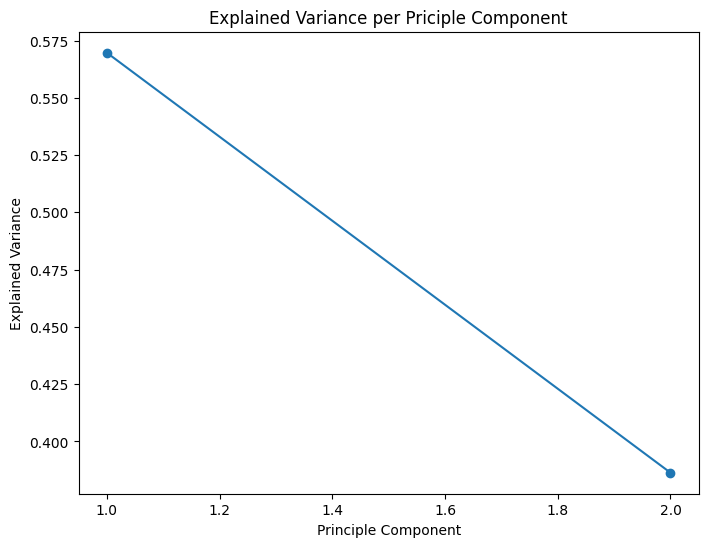

In [55]:
pca = PCA(n_components=2) # the elbow method showed 2 PC are best
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(8, 6))
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_, marker='o')
plt.title('Explained Variance per Priciple Component')
plt.xlabel('Principle Component')
plt.ylabel('Explained Variance')
plt.show()

# Clustering

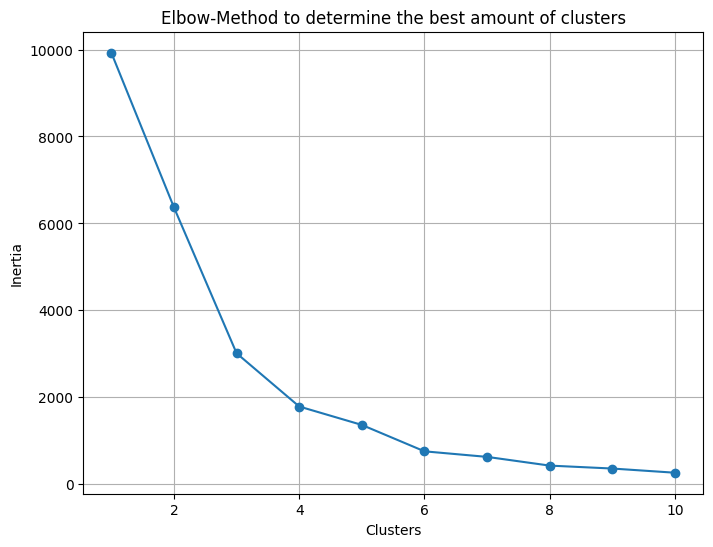

In [56]:
inertia = []
cluster_range = range(1, 11)

for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_pca)
    inertia.append(kmeans.inertia_)

# Elbow-Method to visualize
plt.figure(figsize=(8, 6))
plt.plot(cluster_range, inertia, marker='o')
plt.title('Elbow-Method to determine the best amount of clusters')
plt.xlabel('Clusters')
plt.ylabel('Inertia')
plt.grid(True)
plt.show()


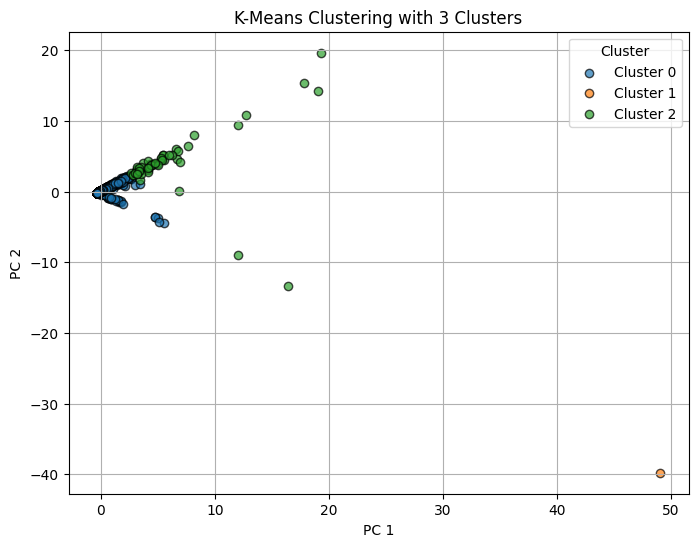

In [59]:
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(X_pca)
df_final['cluster'] = clusters

plt.figure(figsize=(8, 6))

for cluster_label in sorted(set(clusters)):
    plt.scatter(
        X_pca[clusters == cluster_label, 0],
        X_pca[clusters == cluster_label, 1],
        label=f'Cluster {cluster_label}',
        alpha=0.7,
        edgecolors='k'
    )

plt.title('K-Means Clustering with 3 Clusters')
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(title='Cluster')
plt.grid(True)
plt.show()

# Interpretation

In [60]:
df_final.head()

,FIPS,ap,est,emp,current_gdp,cluster
0,10001,3531923,6604,73134,22652836.0,0
1,10003,25246958,27458,431498,243477316.0,0
2,10005,5573830,9178,113649,43727204.0,0
3,10999,11096492,3190,359622,0.0,0
4,11001,69329462,33471,832787,574989171.0,2


In [74]:
cluster_summary = df_final.groupby('cluster')[['ap', 'est', 'emp', 'current_gdp']].mean().reset_index()
print(cluster_summary)

   cluster            ap           est           emp   current_gdp
0        0  4.787424e+06   3160.558048  9.197971e+04  1.679129e+07
1        1  4.946116e+09  27284.000000  8.063490e+07  0.000000e+00
2        2  1.743637e+08  76051.148148  2.387562e+06  6.253709e+08


1.   Cluster 0: Few employment & low GDP
2.   Cluster 1: Highest employement but no GDP.
3.   Cluster 2: Economic top regions with high employment in important industries.


In [103]:
df_result = df_final[(df_final['cluster']==1) | (df_final['cluster']==2)].reset_index(drop=True)
df_result.head()

,FIPS,ap,est,emp,current_gdp,cluster
0,11001,69329462,33471,832787,574989171.0,2
1,12011,92910098,115408,1597109,588080980.0,2
2,12031,63990033,56023,1154301,361484160.0,2
3,12057,103039925,87258,1848437,522828093.0,2
4,12086,84027797,134630,1584501,870680259.0,2


In [98]:
df_result.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55 entries, 0 to 54
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   FIPS         55 non-null     object 
 1   ap           55 non-null     int64  
 2   est          55 non-null     int64  
 3   emp          55 non-null     int64  
 4   current_gdp  55 non-null     float64
 5   cluster      55 non-null     int32  
dtypes: float64(1), int32(1), int64(3), object(1)
memory usage: 2.5+ KB


# Visalization

In [99]:
df_county.head()

,STATEFP,COUNTYFP,COUNTYNS,AFFGEOID,GEOID,NAME,LSAD,ALAND,AWATER,geometry
0,21,007,00516850,0500000US21007,21007,Ballard,06,639387454,69473325,"POLYGON ((-89.18137 37.0463, -89.17938 37.0530..."
1,21,017,00516855,0500000US21017,21017,Bourbon,06,750439351,4829777,"POLYGON ((-84.44266 38.28324, -84.44114 38.283..."
2,21,031,00516862,0500000US21031,21031,Butler,06,1103571974,13943044,"POLYGON ((-86.94486 37.07341, -86.94346 37.074..."
3,21,065,00516879,0500000US21065,21065,Estill,06,655509930,6516335,"POLYGON ((-84.12662 37.6454, -84.12483 37.6461..."
4,21,069,00516881,0500000US21069,21069,Fleming,06,902727151,7182793,"POLYGON ((-83.98428 38.44549, -83.98246 38.450..."


In [100]:
df_state.head()

,STATEFP,STATENS,AFFGEOID,GEOID,STUSPS,NAME,LSAD,ALAND,AWATER,geometry
0,28,01779790,0400000US28,28,MS,Mississippi,00,121533519481,3926919758,"MULTIPOLYGON (((-88.50297 30.21524, -88.49176 ..."
1,37,01027616,0400000US37,37,NC,North Carolina,00,125923656064,13466071395,"MULTIPOLYGON (((-75.72681 35.93584, -75.71827 ..."
2,40,01102857,0400000US40,40,OK,Oklahoma,00,177662925723,3374587997,"POLYGON ((-103.00256 36.52659, -103.00219 36.6..."
3,51,01779803,0400000US51,51,VA,Virginia,00,102257717110,8528531774,"MULTIPOLYGON (((-75.74241 37.80835, -75.74151 ..."
4,54,01779805,0400000US54,54,WV,West Virginia,00,62266474513,489028543,"POLYGON ((-82.6432 38.16909, -82.643 38.16956,..."


In [101]:
# Verknüpfen der Clusterdaten mit den County-Geometriedaten
gdf_cluster = df_county.merge(df_result, left_on='GEOID', right_on='FIPS', how='inner')
gdf_cluster.head()

,STATEFP,COUNTYFP,COUNTYNS,AFFGEOID,GEOID,NAME,LSAD,ALAND,AWATER,geometry,FIPS,ap,est,emp,current_gdp,cluster
0,11,001,01702382,0500000US11001,11001,District of Columbia,00,158340391,18687198,"POLYGON ((-77.11976 38.93434, -77.11253 38.940...",11001,69329462,33471,832787,574989171.0,2
1,12,095,00295750,0500000US12095,12095,Orange,06,2337566033,260717886,"POLYGON ((-81.6586 28.76687, -81.6564 28.76961...",12095,85643151,83075,1468286,551076697.0,2
2,13,121,01694833,0500000US13121,13121,Fulton,06,1364248547,19674940,"POLYGON ((-84.84931 33.51318, -84.84429 33.514...",13121,139237532,75336,1921592,944737533.0,2
3,29,189,00758549,0500000US29189,29189,St. Louis,06,1314228662,40161918,"POLYGON ((-90.73643 38.46985, -90.73614 38.477...",29189,129674918,53432,1741288,434184422.0,2
4,34,003,00882271,0500000US34003,34003,Bergen,06,602910975,35355101,"POLYGON ((-74.27066 41.02103, -74.25046 41.060...",34003,42047060,51433,695280,395105861.0,2


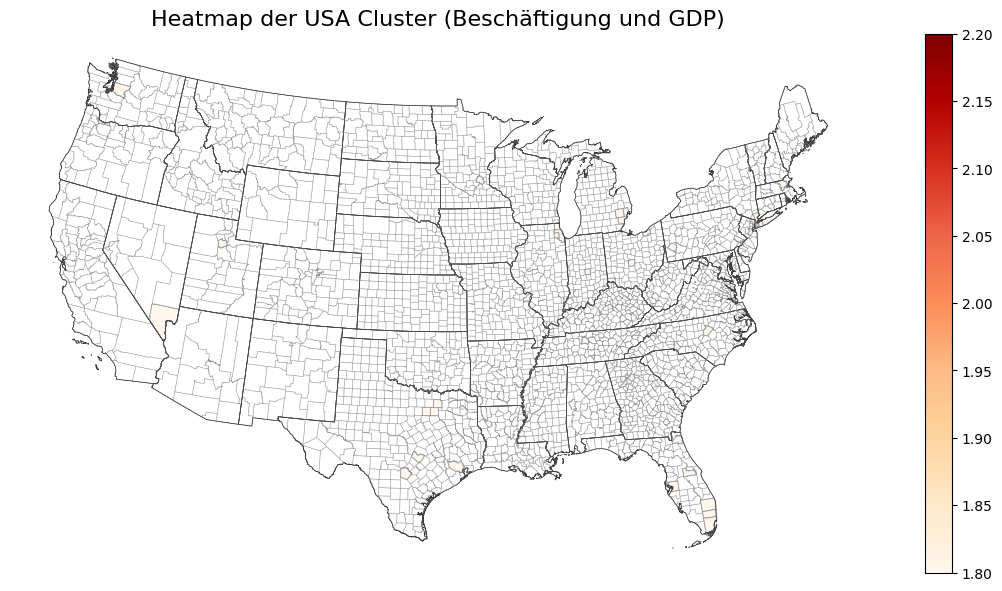

In [102]:
# Sicherstellen, dass gdf_county und gdf_states GeoDataFrames sind
gdf_county = gpd.GeoDataFrame(df_county, geometry='geometry')
gdf_states = gpd.GeoDataFrame(df_state, geometry='geometry')

# Ursprüngliches CRS setzen (falls nicht bereits gesetzt)
gdf_county.crs = 'epsg:4269'  # Beispiel-CRS für USA
gdf_states.crs = 'epsg:4269'

# Nicht-kontinentale Staaten ausschließen
non_contiguous_states = [
    'Alaska', 'Hawaii', 'Puerto Rico',
    'Commonwealth of the Northern Mariana Islands',
    'American Samoa', 'United States Virgin Islands', 'Guam'
]

# Staaten filtern
filtered_states = gdf_states[~gdf_states['NAME'].isin(non_contiguous_states)]

# STATEFP-Codes der gefilterten Staaten erhalten
filtered_statefps = filtered_states['STATEFP'].unique()

# Counties filtern, die in den gefilterten Staaten liegen
filtered_county = gdf_county[gdf_county['STATEFP'].isin(filtered_statefps)]

# Verknüpfen der Cluster-Daten mit den gefilterten County-Daten
gdf_cluster = filtered_county.merge(df_result, left_on='GEOID', right_on='FIPS', how='inner')

# Sicherstellen, dass alle Geodaten im gleichen projizierten CRS sind
# Transformation zu einem geeigneten projizierten CRS (z.B. EPSG:5070 für USA)
gdf_cluster = gdf_cluster.to_crs('epsg:5070')
filtered_states = filtered_states.to_crs('epsg:5070')
filtered_county = filtered_county.to_crs('epsg:5070')

# Erstellung der Karte
fig, ax = plt.subplots(figsize=(15, 7))

# Anpassung der Farbskala für bessere Darstellung
vmin = gdf_cluster['cluster'].min()
vmax = gdf_cluster['cluster'].max()

# Counties mit Clusterfarben darstellen (Heatmap)
gdf_cluster.plot(
    column='cluster',
    cmap='OrRd',
    linewidth=0.8,
    ax=ax,
    edgecolor='0.8',
    legend=True,
    vmin=vmin,
    vmax=vmax
)

# Staaten-Grenzen hinzufügen
filtered_states.boundary.plot(ax=ax, color='black', linewidth=0.5)

# Counties-Grenzen hinzufügen (optional)
filtered_county.boundary.plot(ax=ax, color='gray', linewidth=0.4, alpha=0.5)

# Titel und Achsenformatierung
ax.set_title('Heatmap der USA Cluster (Beschäftigung und GDP)', fontsize=16)
ax.set_axis_off()

# Karte anzeigen
plt.show()


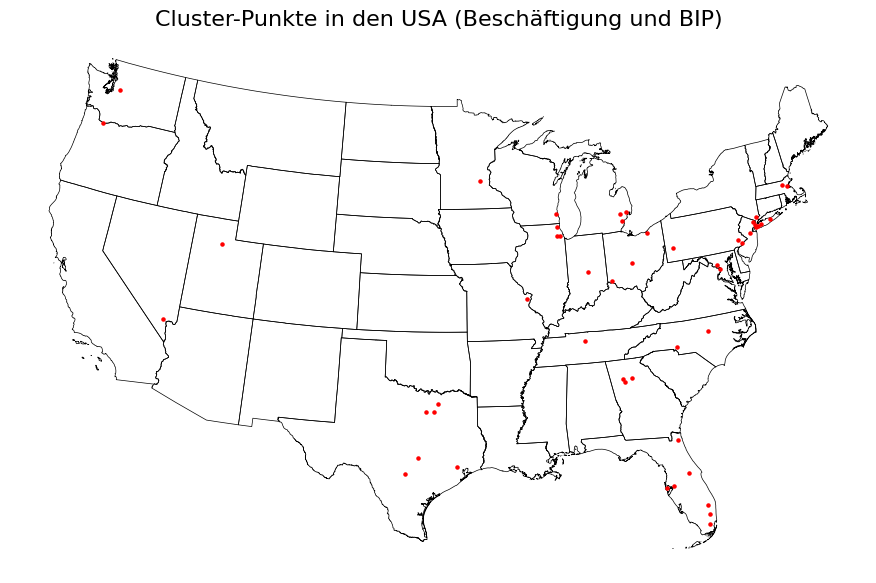

In [104]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Sicherstellen, dass gdf_county und gdf_states GeoDataFrames sind
gdf_county = gpd.GeoDataFrame(df_county, geometry='geometry')
gdf_states = gpd.GeoDataFrame(df_state, geometry='geometry')

# Ursprüngliches CRS setzen (falls nicht bereits gesetzt)
gdf_county.crs = 'epsg:4269'  # NAD83 für die USA
gdf_states.crs = 'epsg:4269'

# Nicht-kontinentale Staaten ausschließen
non_contiguous_states = [
    'Alaska', 'Hawaii', 'Puerto Rico',
    'Commonwealth of the Northern Mariana Islands',
    'American Samoa', 'United States Virgin Islands', 'Guam'
]

# Staaten filtern
filtered_states = gdf_states[~gdf_states['NAME'].isin(non_contiguous_states)]

# STATEFP-Codes der gefilterten Staaten erhalten
filtered_statefps = filtered_states['STATEFP'].unique()

# Counties filtern, die in den gefilterten Staaten liegen
filtered_county = gdf_county[gdf_county['STATEFP'].isin(filtered_statefps)]

# Verknüpfen der Cluster-Daten mit den gefilterten County-Daten
gdf_cluster = filtered_county.merge(df_result, left_on='GEOID', right_on='FIPS', how='inner')

# Sicherstellen, dass alle Geodaten im gleichen projizierten CRS sind
# Transformation zu einem geeigneten projizierten CRS (z.B. EPSG:5070 für USA)
gdf_cluster = gdf_cluster.to_crs('epsg:5070')
filtered_states = filtered_states.to_crs('epsg:5070')
filtered_county = filtered_county.to_crs('epsg:5070')

# Berechnen der Zentroiden der Counties, um Clusterpunkte darzustellen
gdf_cluster['centroid'] = gdf_cluster.geometry.centroid

# Erstellung der Karte
fig, ax = plt.subplots(figsize=(15, 7))

# Staaten ohne Füllfarbe darstellen
filtered_states.plot(ax=ax, color='none', edgecolor='black', linewidth=0.5)

# Cluster-Zentroiden als rote Punkte darstellen
gdf_cluster.set_geometry('centroid').plot(ax=ax, color='red', markersize=5)

# Optional: Counties ohne Füllfarbe darstellen (wenn gewünscht)
# filtered_county.boundary.plot(ax=ax, color='gray', linewidth=0.4, alpha=0.5)

# Titel und Achsenformatierung
ax.set_title('Cluster-Punkte in den USA (Beschäftigung und BIP)', fontsize=16)
ax.set_axis_off()

# Karte anzeigen
plt.show()


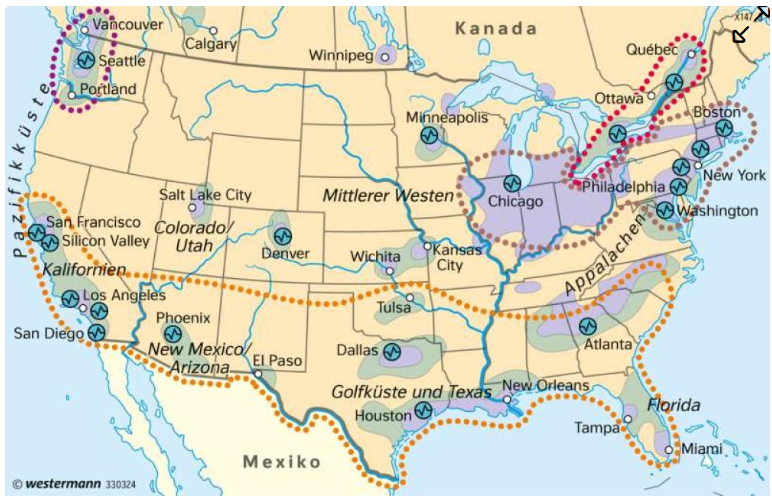

In [106]:
import cv2
from google.colab.patches import cv2_imshow # Import cv2_imshow

image_path = '/content/DDM-Project-WS24-25/usa_economic_key_regions.png'
image = cv2.imread(image_path)

# Bild anzeigen
cv2_imshow(image) # Use cv2_imshow instead of cv2.imshow
cv2.waitKey(0)
cv2.destroyAllWindows()

- The Manufacturing Belt around Chicago and Detroit is the largest and oldest industrial region in the U.S., recently impacted by significant structural change.

- The East Coast metropolitan area, from Boston through New York to Washington, is a leading hub for high-tech industries, diverse manufacturing, and major service centers.

- The Portland/Seattle area is known for strong high-tech and aerospace industries, alongside timber processing and paper manufacturing.

- Economic centers in the West include San Francisco and the Silicon Valley (electronics and computer industries) as well as Los Angeles/San Diego (high-tech, heavy and light industries, and services). Together with mining, industrial, high-tech, and service hubs in Phoenix, Dallas, Houston/New Orleans, Atlanta, and Florida, these regions form the Sunbelt, the U.S. economy's growth area.